In [ ]:
!pip install opencv-python-headless pillow torch torchvision
!pip install matplotlib scikit-image

In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
class MultiLeafPlantDetector:
    def __init__(self):
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.class_names = self._load_class_names()
        self.transform = self._get_transforms()
        self.load_model()

        self.min_leaf_area = 500
        self.max_leaf_area = 10000
        self.min_green_percentage = 5
        self.confidence_threshold = 0.6
        self.leaf_aspect_ratio_range = (0.3, 3.0)

    def _load_class_names(self):
        return ['Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Corn___healthy',
                'Grape___healthy', 'Orange___Haunglongbing', 'Peach___healthy', 'Pepper___healthy',
                'Potato___healthy', 'Strawberry___healthy', 'Tomato___healthy']

    def _get_transforms(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def load_model(self):
        try:
            self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
            self.model.fc = nn.Linear(self.model.fc.in_features, len(self.class_names))
            self.model.to(self.device)
            self.model.eval()
            print("✓ PyTorch model ready")
        except Exception as e:
            print(f"✗ Model loading error: {e}")
            self.model = None

    def is_valid_leaf_region(self, mask, contour):
        area = cv2.contourArea(contour)
        if area < self.min_leaf_area or area > self.max_leaf_area:
            return False, None

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h if h > 0 else 0
        min_ar, max_ar = self.leaf_aspect_ratio_range

        if aspect_ratio < min_ar or aspect_ratio > max_ar:
            return False, None

        roi_mask = mask[y:y+h, x:x+w]
        if roi_mask.size == 0:
            return False, None

        green_density = cv2.countNonZero(roi_mask) / (w * h) if w * h > 0 else 0

        perimeter = cv2.arcLength(contour, True)
        if perimeter > 0:
            circularity = 4 * np.pi * area / (perimeter * perimeter)
        else:
            circularity = 0

        is_valid = green_density > 0.2 and 0.1 < circularity < 0.8

        leaf_info = {
            'contour': contour,
            'bbox': (x, y, w, h),
            'area': area,
            'aspect_ratio': aspect_ratio,
            'circularity': circularity,
            'green_density': green_density
        }

        return is_valid, leaf_info

    def detect_multiple_leaves(self, image):
        small = cv2.resize(image, (640, 480))
        hsv = cv2.cvtColor(small, cv2.COLOR_BGR2HSV)

        green_ranges = [
            ([35, 40, 40], [85, 255, 255]),
            ([25, 40, 40], [35, 255, 255]),
            ([85, 40, 40], [95, 255, 255]),
        ]

        combined_mask = np.zeros(small.shape[:2], dtype=np.uint8)

        for lower, upper in green_ranges:
            mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
            combined_mask = cv2.bitwise_or(combined_mask, mask)

        kernel_open = np.ones((3,3), np.uint8)
        kernel_close = np.ones((7,7), np.uint8)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel_open)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel_close)

        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        leaves = []
        leaf_mask = np.zeros_like(combined_mask)

        for contour in contours:
            is_valid, leaf_info = self.is_valid_leaf_region(combined_mask, contour)
            if is_valid:
                leaves.append(leaf_info)
                cv2.drawContours(leaf_mask, [contour], -1, 255, -1)

        leaves.sort(key=lambda x: x['area'], reverse=True)

        green_pct = (cv2.countNonZero(leaf_mask) / leaf_mask.size) * 100
        return green_pct, leaves, leaf_mask, small

    def analyze_individual_leaf(self, image, leaf_info):
        x, y, w, h = leaf_info['bbox']

        leaf_roi = image[y:y+h, x:x+w]
        if leaf_roi.size == 0:
            return None

        hsv_leaf = cv2.cvtColor(leaf_roi, cv2.COLOR_BGR2HSV)

        green_channel = leaf_roi[:, :, 1]
        green_avg = np.mean(green_channel)

        gray_leaf = cv2.cvtColor(leaf_roi, cv2.COLOR_BGR2GRAY)
        disease_mask = cv2.adaptiveThreshold(gray_leaf, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY_INV, 11, 2)

        kernel = np.ones((3,3), np.uint8)
        disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_OPEN, kernel)

        disease_pct = (np.count_nonzero(disease_mask) / disease_mask.size) * 100

        health_score = max(0, min(100, 100 - disease_pct * 2))
        health_status = "Healthy" if disease_pct < 8 else "Slight Issues" if disease_pct < 20 else "Needs Attention"

        return {
            'bbox': leaf_info['bbox'],
            'area': leaf_info['area'],
            'health_status': health_status,
            'health_score': health_score,
            'disease_pct': disease_pct,
            'green_avg': green_avg,
            'aspect_ratio': leaf_info['aspect_ratio']
        }

    def predict_health_multiple_leaves(self, image):
        try:
            green_pct, leaves, mask, processed = self.detect_multiple_leaves(image)

            if not leaves:
                return {
                    'detected': False,
                    'message': 'No leaves detected',
                    'confidence': 0.0,
                    'green_pct': green_pct,
                    'leaves': []
                }

            leaf_analyses = []
            for i, leaf_info in enumerate(leaves[:6]):
                analysis = self.analyze_individual_leaf(processed, leaf_info)
                if analysis:
                    analysis['leaf_id'] = i + 1
                    leaf_analyses.append(analysis)

            if leaf_analyses:
                avg_health = np.mean([leaf['health_score'] for leaf in leaf_analyses])
                overall_status = "Healthy" if avg_health > 80 else "Good" if avg_health > 60 else "Needs Attention"

                return {
                    'detected': True,
                    'overall_status': overall_status,
                    'avg_health_score': avg_health,
                    'confidence': max(0.6, min(0.95, avg_health / 100)),
                    'green_pct': green_pct,
                    'leaves_detected': len(leaf_analyses),
                    'leaf_analyses': leaf_analyses
                }
            else:
                return {
                    'detected': False,
                    'message': 'No valid leaves analyzed',
                    'confidence': 0.0,
                    'green_pct': green_pct,
                    'leaves': []
                }

        except Exception as e:
            return {'detected': False, 'message': f'Error: {str(e)}', 'confidence': 0.0, 'leaves': []}

In [ ]:
detector = MultiLeafPlantDetector()
print("Detector initialized successfully!")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


✓ PyTorch model ready
Detector initialized successfully!


In [ ]:
from google.colab import files

# Upload image
print("Upload an image of plant leaves:")
uploaded = files.upload()

# Get the uploaded filename
image_path = list(uploaded.keys())[0]
print(f"Processing: {image_path}")

# Read image
image = cv2.imread(image_path)
if image is None:
    print("Error reading image")
else:
    print(f"Image shape: {image.shape}")

Upload an image of plant leaves:


Saving unhealthy-tree-leaves-tree-surgeon.jpg to unhealthy-tree-leaves-tree-surgeon.jpg
Processing: unhealthy-tree-leaves-tree-surgeon.jpg
Image shape: (918, 2156, 3)


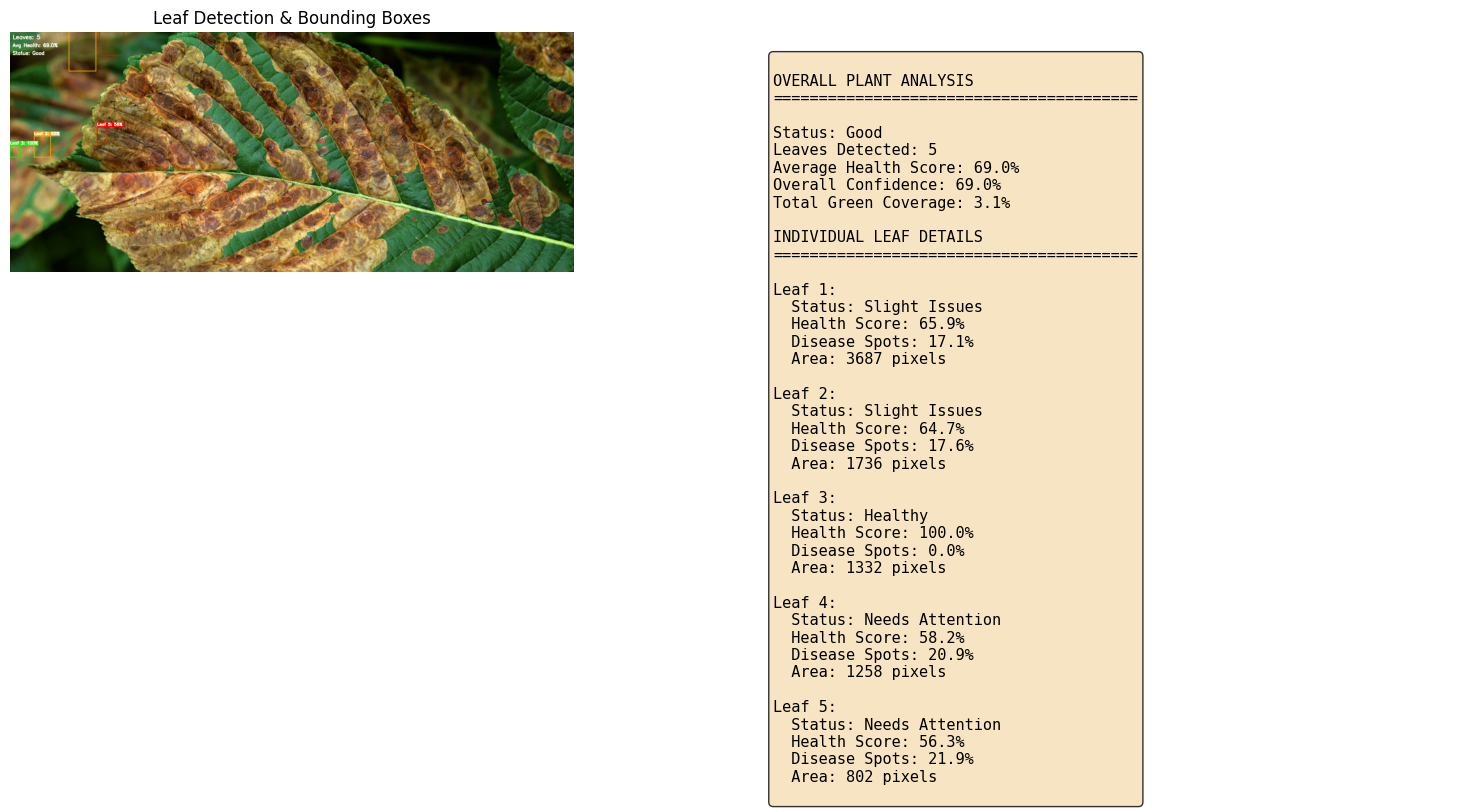


ANALYSIS RESULTS
Leaves Detected: 5
Overall Status: Good
Average Health Score: 69.0%
Confidence: 69.0%

Leaf 1:
  Status: Slight Issues
  Health Score: 65.9%
  Disease Spots: 17.1%
Leaf 2:
  Status: Slight Issues
  Health Score: 64.7%
  Disease Spots: 17.6%
Leaf 3:
  Status: Healthy
  Health Score: 100.0%
  Disease Spots: 0.0%
Leaf 4:
  Status: Needs Attention
  Health Score: 58.2%
  Disease Spots: 20.9%
Leaf 5:
  Status: Needs Attention
  Health Score: 56.3%
  Disease Spots: 21.9%


In [ ]:
def visualize_results(image, result):
    """Visualize detection results with bounding boxes"""
    if not result['detected']:
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"No leaves detected: {result['message']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        return

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Draw bounding boxes
    overlay = image.copy()
    for leaf in result['leaf_analyses']:
        x, y, w, h = leaf['bbox']
        box_color = (0, 255, 0) if leaf['health_status'] == "Healthy" else (0, 165, 255) if leaf['health_status'] == "Slight Issues" else (0, 0, 255)

        cv2.rectangle(overlay, (x, y), (x + w, y + h), box_color, 2)

        label_text = f"Leaf {leaf['leaf_id']}: {leaf['health_score']:.0f}%"
        label_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        cv2.rectangle(overlay, (x, y - label_size[1] - 5), (x + label_size[0], y), box_color, -1)
        cv2.putText(overlay, label_text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Add overall info
    cv2.putText(overlay, f"Leaves: {result['leaves_detected']}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    cv2.putText(overlay, f"Avg Health: {result['avg_health_score']:.1f}%", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(overlay, f"Status: {result['overall_status']}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    axes[0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Leaf Detection & Bounding Boxes")
    axes[0].axis('off')

    # Plot results
    axes[1].axis('off')
    results_text = f"""
OVERALL PLANT ANALYSIS
{'='*40}

Status: {result['overall_status']}
Leaves Detected: {result['leaves_detected']}
Average Health Score: {result['avg_health_score']:.1f}%
Overall Confidence: {result['confidence']:.1%}
Total Green Coverage: {result['green_pct']:.1f}%

INDIVIDUAL LEAF DETAILS
{'='*40}
"""

    for leaf in result['leaf_analyses']:
        results_text += f"""
Leaf {leaf['leaf_id']}:
  Status: {leaf['health_status']}
  Health Score: {leaf['health_score']:.1f}%
  Disease Spots: {leaf['disease_pct']:.1f}%
  Area: {leaf['area']:.0f} pixels
"""

    axes[1].text(0.1, 0.9, results_text, transform=axes[1].transAxes, fontsize=11,
                verticalalignment='top', fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Run analysis
result = detector.predict_health_multiple_leaves(image)
visualize_results(image, result)

# Print detailed results
print("\n" + "="*50)
print("ANALYSIS RESULTS")
print("="*50)
print(f"Leaves Detected: {result['leaves_detected']}")
print(f"Overall Status: {result['overall_status']}")
print(f"Average Health Score: {result['avg_health_score']:.1f}%")
print(f"Confidence: {result['confidence']:.1%}\n")

for leaf in result['leaf_analyses']:
    print(f"Leaf {leaf['leaf_id']}:")
    print(f"  Status: {leaf['health_status']}")
    print(f"  Health Score: {leaf['health_score']:.1f}%")
    print(f"  Disease Spots: {leaf['disease_pct']:.1f}%")

In [ ]:
def batch_process_images(image_paths, detector):
    """Process multiple images"""
    results_summary = []

    for img_path in image_paths:
        image = cv2.imread(img_path)
        if image is None:
            print(f"Skipped: {img_path}")
            continue

        result = detector.predict_health_multiple_leaves(image)
        result['image_path'] = img_path
        results_summary.append(result)

        print(f"✓ {img_path}: {result['overall_status']} ({result['leaves_detected']} leaves)")

    return results_summary

# Example: Process multiple uploaded images
uploaded = files.upload()
results = batch_process_images(list(uploaded.keys()), detector)

# Save results to CSV
import pandas as pd

summary_data = []
for result in results:
    if result['detected']:
        summary_data.append({
            'Image': result['image_path'],
            'Status': result['overall_status'],
            'Leaves': result['leaves_detected'],
            'Avg Health': f"{result['avg_health_score']:.1f}%",
            'Confidence': f"{result['confidence']:.1%}"
        })

df = pd.DataFrame(summary_data)
df.to_csv('plant_analysis_results.csv', index=False)
print("\nResults saved to plant_analysis_results.csv")
print(df)

Saving unhealthy-leaf-spot-diseases-that-260nw-1163818984.webp to unhealthy-leaf-spot-diseases-that-260nw-1163818984.webp
Saving istockphoto-848782862-612x612.jpg to istockphoto-848782862-612x612.jpg
Saving depositphotos_311981452-stock-photo-closeup-unhealthy-leaves.jpg to depositphotos_311981452-stock-photo-closeup-unhealthy-leaves.jpg
✓ unhealthy-leaf-spot-diseases-that-260nw-1163818984.webp: Healthy (1 leaves)
✓ istockphoto-848782862-612x612.jpg: Needs Attention (3 leaves)
✓ depositphotos_311981452-stock-photo-closeup-unhealthy-leaves.jpg: Good (4 leaves)

Results saved to plant_analysis_results.csv
                                               Image           Status  Leaves  \
0  unhealthy-leaf-spot-diseases-that-260nw-116381...          Healthy       1   
1                  istockphoto-848782862-612x612.jpg  Needs Attention       3   
2  depositphotos_311981452-stock-photo-closeup-un...             Good       4   

  Avg Health Confidence  
0      83.9%      83.9%  
1      59.8%

In [ ]:
from IPython.display import Javascript
from google.colab.output import eval_js
import base64
from io import BytesIO

def capture_photo():
    """Capture photo from Colab camera"""
    js = Javascript('''
    async function takePhoto(quality = 0.8) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      if (navigator.mediaDevices && navigator.mediaDevices.getUserMedia) {
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();

        document.body.appendChild(div);
        document.body.appendChild(video);

        // Capture on button click
        google.colab.kernel.invokeFunction('notebook.get_image', [], {});
        capture.onclick = () => {
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          video.remove();
          google.colab.kernel.invokeFunction('notebook.save_photo', [canvas.toDataURL('image/jpeg')], {});
        };
      }
    }
    takePhoto();
    ''')
    display(js)

# Capture and process
# Note: This requires manual interaction
capture_photo()

<IPython.core.display.Javascript object>